In [3]:
!pip install yfinance

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [6]:
def get_stoch_osc(high, low, close, k_lookback, d_lookback):
    lowest_low = low.rolling(k_lookback).min()
    highest_high = high.rolling(k_lookback).max()
    k_line = ((close - lowest_low) / (highest_high - lowest_low)) * 100
    d_line = k_line.rolling(d_lookback).mean()
    return k_line, d_line

In [7]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span=fast, adjust=False).mean()
    exp2 = price.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=smooth, adjust=False).mean()
    histogram = macd - signal
    return macd, signal, histogram

In [8]:
def stoch_macd_strategy(prices, k_line, d_line, macd, macd_signal):
    buy_price = []
    sell_price = []
    stoch_macd_signal = []
    signal = 0

    # Convert Pandas Series to NumPy arrays to use integer indexing
    prices = prices.values
    k_line = k_line.values
    d_line = d_line.values
    macd = macd.values
    macd_signal = macd_signal.values

    for i in range(len(prices)):
        # Buy condition: Stochastic Oscillator is oversold and MACD is bearish
        if k_line[i] < 30 and d_line[i] < 30 and macd[i] < 0 and macd_signal[i] < 0:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)

        # Sell condition: Stochastic Oscillator is overbought and MACD is bullish
        elif k_line[i] > 70 and d_line[i] > 70 and macd[i] > 0 and macd_signal[i] > 0:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_macd_signal.append(0)

    return buy_price, sell_price, stoch_macd_signal

In [9]:
def get_historical_data(symbol, start_date, end_date=None):
    """
    Fetch historical stock data using yfinance

    Parameters:
    symbol (str): Stock ticker symbol
    start_date (str): Start date for data retrieval (YYYY-MM-DD)
    end_date (str, optional): End date for data retrieval. Defaults to None (current date).

    Returns:
    pandas.DataFrame: DataFrame with stock data
    """
    # Fetch data using yfinance
    df = yf.download(symbol, start=start_date, end=end_date)

    # Rename columns to match original code
    df = df.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'adj_close',
        'Volume': 'volume'
    })

    return df


In [10]:
full_data_df = get_historical_data('RELIANCE.NS', '2015-01-01', '2024-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [11]:
df=full_data_df

In [12]:
df

Price,close,high,low,open,volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2015-01-01,181.798340,182.637822,180.928146,181.470748,2963643
2015-01-02,181.317169,183.467061,181.061238,181.839283,7331366
2015-01-05,179.331100,182.412610,178.972783,181.204573,10103941
2015-01-06,171.192245,178.747558,170.352763,178.133309,18627980
2015-01-07,174.918716,175.840097,171.376531,171.397005,20720312
...,...,...,...,...,...
2023-12-22,1273.848755,1281.720070,1265.207538,1271.142214,16541784
2023-12-26,1280.304810,1287.207745,1272.681682,1275.313779,7465664


In [13]:
# def evaluate_strategy(symbol):
#     # Fetch historical data
#     full_data = get_historical_data(symbol, '2015-01-01', '2024-01-01')
#     test_data = get_historical_data(symbol, '2024-01-01')

#     # Calculate indicators for training data
#     full_data['%k'], full_data['%d'] = get_stoch_osc(full_data['high'], full_data['low'], full_data['close'], 14, 3)
#     full_data['macd'], full_data['macd_signal'], full_data['macd_hist'] = get_macd(full_data['close'], 26, 12, 9)
#     full_data = full_data.dropna()

#     # Apply strategy to test data
#     test_data['%k'], test_data['%d'] = get_stoch_osc(test_data['high'], test_data['low'], test_data['close'], 14, 3)
#     test_data['macd'], test_data['macd_signal'], test_data['macd_hist'] = get_macd(test_data['close'], 26, 12, 9)
#     test_data = test_data.dropna()

#     # Generate buy/sell signals using strategy
#     buy_price, sell_price, stoch_macd_signal = stoch_macd_strategy(
#         test_data['close'],
#         test_data['%k'],
#         test_data['%d'],
#         test_data['macd'],
#         test_data['macd_signal']
#     )

#     # Calculate strategy position
#     position = []
#     for i in range(len(stoch_macd_signal)):
#         if stoch_macd_signal[i] > 1:
#             position.append(0)
#         else:
#             position.append(1)

#     for i in range(len(test_data['close'])):
#         if stoch_macd_signal[i] == 1:
#             position[i] = 1
#         elif stoch_macd_signal[i] == -1:
#             position[i] = 0
#         else:
#             position[i] = position[i-1] if i > 0 else 1

#     # Calculate returns
#     test_rets = test_data['close'].pct_change().dropna()
#     strat_rets = pd.Series(position[1:]) * test_rets

#     # Cumulative returns
#     buy_hold_cumulative_return = float((1 + test_rets).cumprod().iloc[-1] - 1)
#     strategy_cumulative_return = float((1 + strat_rets).cumprod().iloc[-1] - 1)

#     # Initial and final investment values
#     initial_investment = 100000  # Example initial investment amount

#     # Plotting
#     plt.figure(figsize=(15,7))
#     plt.title(f'{symbol} Cumulative Returns')

#     buy_hold_cumulative = (1 + test_rets).cumprod()
#     strat_cumulative = (1 + strat_rets).cumprod()

#     # Calculate final values and profit
#     buy_hold_final_value = initial_investment * (1 + buy_hold_cumulative_return)
#     strategy_final_value = initial_investment * (1 + strategy_cumulative_return)

#     # Correct way to convert to float
#     buy_hold_profit = buy_hold_final_value - initial_investment
#     strategy_profit = strategy_final_value - initial_investment

#     buy_hold_final_value_float = buy_hold_final_value if isinstance(buy_hold_final_value, (int, float)) else buy_hold_final_value.iloc[-1]
#     strategy_final_value_float = strategy_final_value.iloc[-1] if isinstance(strategy_final_value, pd.Series) else strategy_final_value


#     # plt.xlabel('Date')
#     # plt.ylabel('Cumulative Returns')
#     # plt.legend()
#     # plt.tight_layout()
#     # plt.show()

#     # Plot both cumulative returns in the same graph
#     plt.figure(figsize=(15, 7))
#     plt.title(f'{symbol} Cumulative Returns')

#     buy_hold_cumulative.plot(label=f'Buy and Hold (Profit: ₹{buy_hold_final_value_float-initial_investment:,.2f})', alpha=0.7)
#     strat_cumulative.plot(label=f'Strategy (Profit: ₹{strategy_final_value_float-initial_investment:,.2f})', color='red')

#     plt.xlabel('Date')
#     plt.ylabel('Cumulative Returns')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
#         # Performance metrics
#     print(f"Buy and Hold Cumulative Return: {buy_hold_cumulative_return*100:.2f}%")
#     print(f"Strategy Cumulative Return: {strategy_cumulative_return*100:.2f}%")
#     print(f"Outperformance Over Benchmark: {(strategy_cumulative_return - buy_hold_cumulative_return)*100:.2f}%")

#     return test_data, strat_rets

In [14]:
def evaluate_strategy(symbol):
    # Fetch historical data
    full_data = get_historical_data(symbol, '2015-01-01', '2024-01-01')
    test_data = get_historical_data(symbol, '2024-01-01')

    # Calculate indicators for training data
    full_data['%k'], full_data['%d'] = get_stoch_osc(full_data['high'], full_data['low'], full_data['close'], 14, 3)
    full_data['macd'], full_data['macd_signal'], full_data['macd_hist'] = get_macd(full_data['close'], 26, 12, 9)
    full_data = full_data.dropna()

    # Apply strategy to test data
    test_data['%k'], test_data['%d'] = get_stoch_osc(test_data['high'], test_data['low'], test_data['close'], 14, 3)
    test_data['macd'], test_data['macd_signal'], test_data['macd_hist'] = get_macd(test_data['close'], 26, 12, 9)
    test_data = test_data.dropna()

    # Generate buy/sell signals using strategy
    buy_price, sell_price, stoch_macd_signal = stoch_macd_strategy(
        test_data['close'],
        test_data['%k'],
        test_data['%d'],
        test_data['macd'],
        test_data['macd_signal']
    )

    # Calculate strategy position
    position = [1]  # Start by holding the stock (buy & hold)

    for i in range(1, len(stoch_macd_signal)):
        if stoch_macd_signal[i] == 1:
            position.append(1)  # Buy
        elif stoch_macd_signal[i] == -1:
            position.append(0)  # Sell
        else:
            position.append(position[-1])  # Carry forward previous position

    # Convert position to a Pandas Series for proper alignment
    position = pd.Series(position, index=test_data.index)

    # Calculate returns
    test_rets = test_data['close'].pct_change().dropna()
    strat_rets = position.shift(1) * test_rets  # Align positions properly

    # Cumulative returns
    buy_hold_cumulative = (1 + test_rets).cumprod()
    strat_cumulative = (1 + strat_rets).cumprod()

    # Final investment values
    initial_investment = 100000  # Example initial investment amount

    buy_hold_cumulative_return = float(buy_hold_cumulative.iloc[-1] - 1)
    strategy_cumulative_return = float(strat_cumulative.iloc[-1] - 1)

    buy_hold_final_value = initial_investment * (1 + buy_hold_cumulative_return)
    strategy_final_value = initial_investment * (1 + strategy_cumulative_return)

    # Fix: Extract scalar value if it's a Series
    buy_hold_final_value = buy_hold_final_value.iloc[0] if isinstance(buy_hold_final_value, pd.Series) else buy_hold_final_value
    strategy_final_value = strategy_final_value.iloc[0] if isinstance(strategy_final_value, pd.Series) else strategy_final_value

    buy_hold_profit = buy_hold_final_value - initial_investment
    strategy_profit = strategy_final_value - initial_investment

    # Plot both cumulative returns in the same graph
    plt.figure(figsize=(15, 7))
    plt.title(f'{symbol} Cumulative Returns')

    buy_hold_cumulative.plot(label=f'Buy and Hold (Profit: ₹{buy_hold_profit:,.2f})', alpha=0.7)
    strat_cumulative.plot(label=f'Strategy (Profit: ₹{strategy_profit:,.2f})', color='red')

    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Performance metrics
    print(f"Buy and Hold Cumulative Return: {buy_hold_cumulative_return*100:.2f}%")
    print(f"Strategy Cumulative Return: {strategy_cumulative_return*100:.2f}%")
    print(f"Outperformance Over Benchmark: {(strategy_cumulative_return - buy_hold_cumulative_return)*100:.2f}%")

    return test_data, strat_rets


In [28]:
df=get_historical_data('IRFC.NS','2015-01-01','2024-01-01')

[*********************100%***********************]  1 of 1 completed


In [29]:
df

Price,close,high,low,open,volume
Ticker,IRFC.NS,IRFC.NS,IRFC.NS,IRFC.NS,IRFC.NS
Date,,,,,
2021-01-29,21.033579,21.881707,20.651922,21.118392,381938573
2021-02-01,21.288019,21.542457,21.118393,21.415238,72044464
2021-02-02,20.991173,21.584863,20.948767,21.584863,36735442
2021-02-03,20.567112,21.118395,20.397486,21.033582,45816269
2021-02-04,21.500051,21.881708,20.227859,20.567110,88486029
...,...,...,...,...,...
2023-12-22,96.239685,100.325566,95.156682,99.439470,137646820
2023-12-26,95.895096,97.765741,95.058230,96.978098,77725407


In [30]:
df.columns = [col[0] for col in df.columns]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 722 entries, 2021-01-29 to 2023-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   722 non-null    float64
 1   high    722 non-null    float64
 2   low     722 non-null    float64
 3   open    722 non-null    float64
 4   volume  722 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 33.8 KB


In [32]:
train_data = df.iloc[:-252]  # Last 252 trading days (~1 year) for testing
test_data = df.iloc[-252:]

In [33]:
def get_stoch_osc(high, low, close, k_lookback=14, d_lookback=3):
    lowest_low = low.rolling(k_lookback).min()
    highest_high = high.rolling(k_lookback).max()
    k_line = ((close - lowest_low) / (highest_high - lowest_low)) * 100
    d_line = k_line.rolling(d_lookback).mean()
    return k_line, d_line

df['%K'], df['%D'] = get_stoch_osc(df['high'], df['low'], df['close'])

In [34]:
def get_macd(price, slow=26, fast=12, smooth=9):
    exp1 = price.ewm(span=fast, adjust=False).mean()
    exp2 = price.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=smooth, adjust=False).mean()
    return macd, signal

df['MACD'], df['MACD_Signal'] = get_macd(df['close'])


In [35]:
def implement_stoch_macd_strategy(prices, k, d, macd, macd_signal):
    buy_price = []
    sell_price = []
    signal = 0

    for i in range(len(prices)):
        if k[i] < 30 and d[i] < 30 and macd[i] < macd_signal[i]:  # Buy signal
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)

        elif k[i] > 70 and d[i] > 70 and macd[i] > macd_signal[i]:  # Sell signal
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)

        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)

    return buy_price, sell_price

df['Buy_Signal'], df['Sell_Signal'] = implement_stoch_macd_strategy(df['close'], df['%K'], df['%D'], df['MACD'], df['MACD_Signal'])


<ipython-input-35-64016b4c1982>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if k[i] < 30 and d[i] < 30 and macd[i] < macd_signal[i]:  # Buy signal
<ipython-input-35-64016b4c1982>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif k[i] > 70 and d[i] > 70 and macd[i] > macd_signal[i]:  # Sell signal
<ipython-input-35-64016b4c1982>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sell_price.append(prices[i])
<ipython-input-35

In [36]:
test_data

,close,high,low,open,volume
Date,,,,,
2022-12-22,30.174994,32.251035,29.933594,31.864793,99443583
2022-12-23,26.891954,29.885314,26.602273,29.885314,122876842
2022-12-26,29.305952,29.740471,26.891953,27.278192,136601051
2022-12-27,30.995750,31.285433,29.981871,30.223271,89075438
2022-12-28,31.381994,32.057915,30.464674,31.044036,104597559
...,...,...,...,...,...
2023-12-22,96.239685,100.325566,95.156682,99.439470,137646820
2023-12-26,95.895096,97.765741,95.058230,96.978098,77725407
2023-12-27,95.205910,97.371923,94.713635,96.485827,48428319


<ipython-input-38-d8e769039852>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Returns'] = test_data['close'].pct_change()
<ipython-input-38-d8e769039852>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Strategy_Returns'] = test_data['Returns'] * df['Buy_Signal'].notna().astype(int)
<ipython-input-38-d8e769039852>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

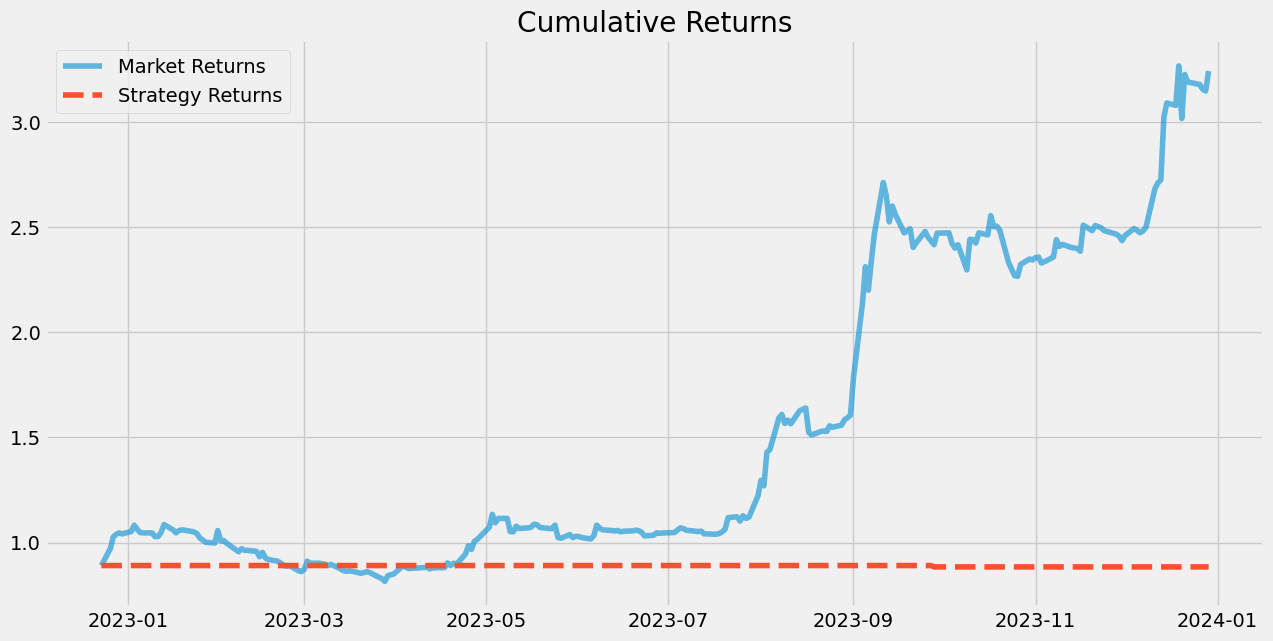

In [38]:
# Returns Calculation
test_data['Returns'] = test_data['close'].pct_change()
test_data['Strategy_Returns'] = test_data['Returns'] * df['Buy_Signal'].notna().astype(int)

# Cumulative Performance
test_data['Cumulative_Market'] = (1 + test_data['Returns']).cumprod()
test_data['Cumulative_Strategy'] = (1 + test_data['Strategy_Returns']).cumprod()

# Plot Cumulative Returns
plt.figure(figsize=(14,7))
plt.plot(test_data['Cumulative_Market'], label="Market Returns", alpha=0.6)
plt.plot(test_data['Cumulative_Strategy'], label="Strategy Returns", linestyle="dashed")
plt.title("Cumulative Returns")
plt.legend()
plt.show()


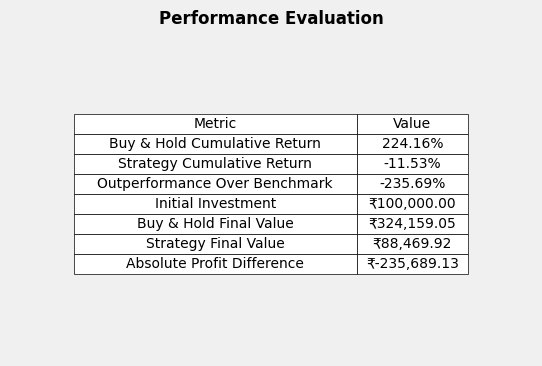

In [39]:
def display_performance_metrics(metrics):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axis("off")

    df_metrics = pd.DataFrame(metrics)
    table = ax.table(cellText=df_metrics.values, colLabels=df_metrics.columns, cellLoc="center", loc="center")

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width([0, 1])
    table.scale(1.2, 1.2)

    plt.title("Performance Evaluation", fontsize=12, fontweight='bold')
    plt.show()

# Calculate Metrics
initial_investment = 100000
final_market_value = initial_investment * test_data['Cumulative_Market'].iloc[-1]
final_strategy_value = initial_investment * test_data['Cumulative_Strategy'].iloc[-1]
outperformance = (final_strategy_value - final_market_value)

performance_metrics = {
    "Metric": [
        "Buy & Hold Cumulative Return",
        "Strategy Cumulative Return",
        "Outperformance Over Benchmark",
        "Initial Investment",
        "Buy & Hold Final Value",
        "Strategy Final Value",
        "Absolute Profit Difference"
    ],
    "Value": [
        f"{(test_data['Cumulative_Market'].iloc[-1] - 1) * 100:.2f}%",
        f"{(test_data['Cumulative_Strategy'].iloc[-1] - 1) * 100:.2f}%",
        f"{outperformance / initial_investment * 100:.2f}%",
        f"₹{initial_investment:,.2f}",
        f"₹{final_market_value:,.2f}",
        f"₹{final_strategy_value:,.2f}",
        f"₹{outperformance:,.2f}"
    ]
}

display_performance_metrics(performance_metrics)
